### Motivation

Consumer banks hold a large amount of information on their clients. This vast amount of information can be mined for data to generate deeper insights into customer profiles and segments, in turn allowing the bank to conduct marketing campaigns that are more targeted. 

In this project, I aim to investigating customer characteristics that make them most likely to take up products from the bank. I have used the UCI Machine Learning repository's Bank Marketing data set. The product in question is a term deposit, but the analysis can easily be tweaked to reflect any potential product the bank wishes to sell to its customers e.g. credit cards, mortgage loans and bancassurance. 

Questions I hope to answer include:
- Which time of the year is best to launch a marketing campaign?
- How does the customer's age, level of education and type of job affect the likelihood of taking up a term deposit?
- Which other characteristics of a customer are most important when determining the likelihood of taking up a term deposit? 
- What marketing strategies can the bank adopt to improve on the effectiveness of its campaign?

### Workflow

1. EDA 
2. Feature Engineering
3. Model Implementation
4. Results and Conclusions

### EDA

In [2]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import pydotplus


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%time

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.01 µs


In [3]:
bank = pd.read_csv('./bank-additional-full.csv', sep=';')

The data dictionary is as follows:

1 - age (numeric) <br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') <br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>
8 - contact: contact communication type (categorical: 'cellular','telephone') <br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric) <br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) <br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')<br>

In [4]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

As mentioned in the data dictionary, I will drop 'duration' as the duration of a call cannot be determined before it is performed. 

In [6]:
bank = bank.drop('duration', axis = 1)

In [8]:
# convert yes/no column for campaign result to 1 and 0
bank.y.replace('yes', 1, inplace=True)
bank.y.replace('no', 0, inplace=True)

In [9]:
bank.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


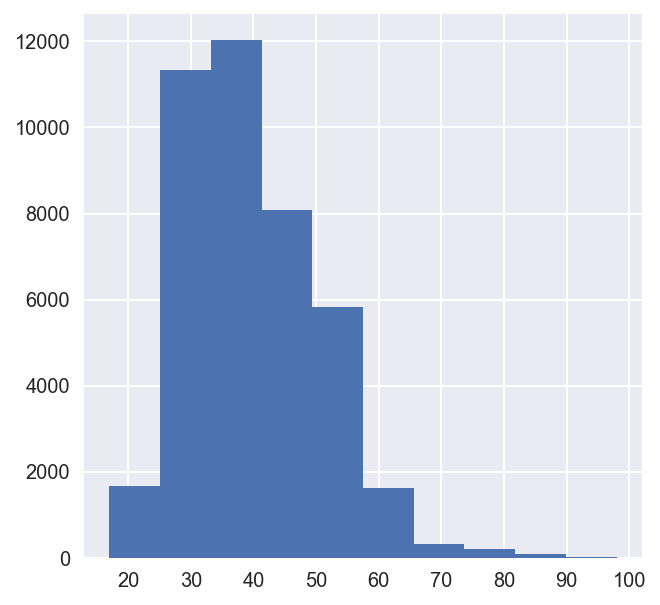

In [10]:
bank.age.hist(bins=10, figsize=(5,5))
plt.show()

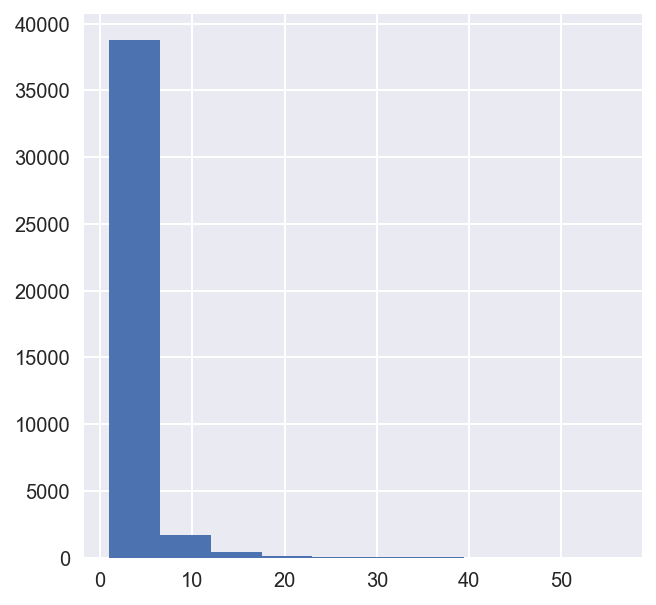

In [11]:
bank.campaign.hist(bins=10, figsize=(5,5))
plt.show()

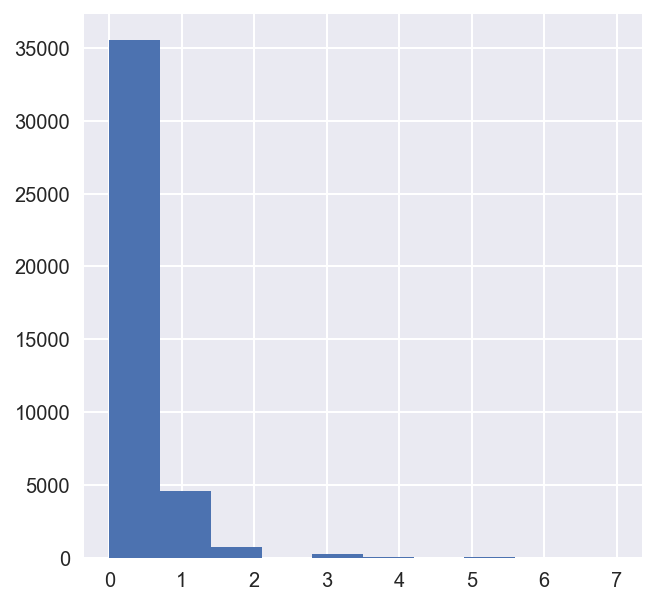

In [12]:
bank.previous.hist(bins=10, figsize=(5,5))
plt.show()

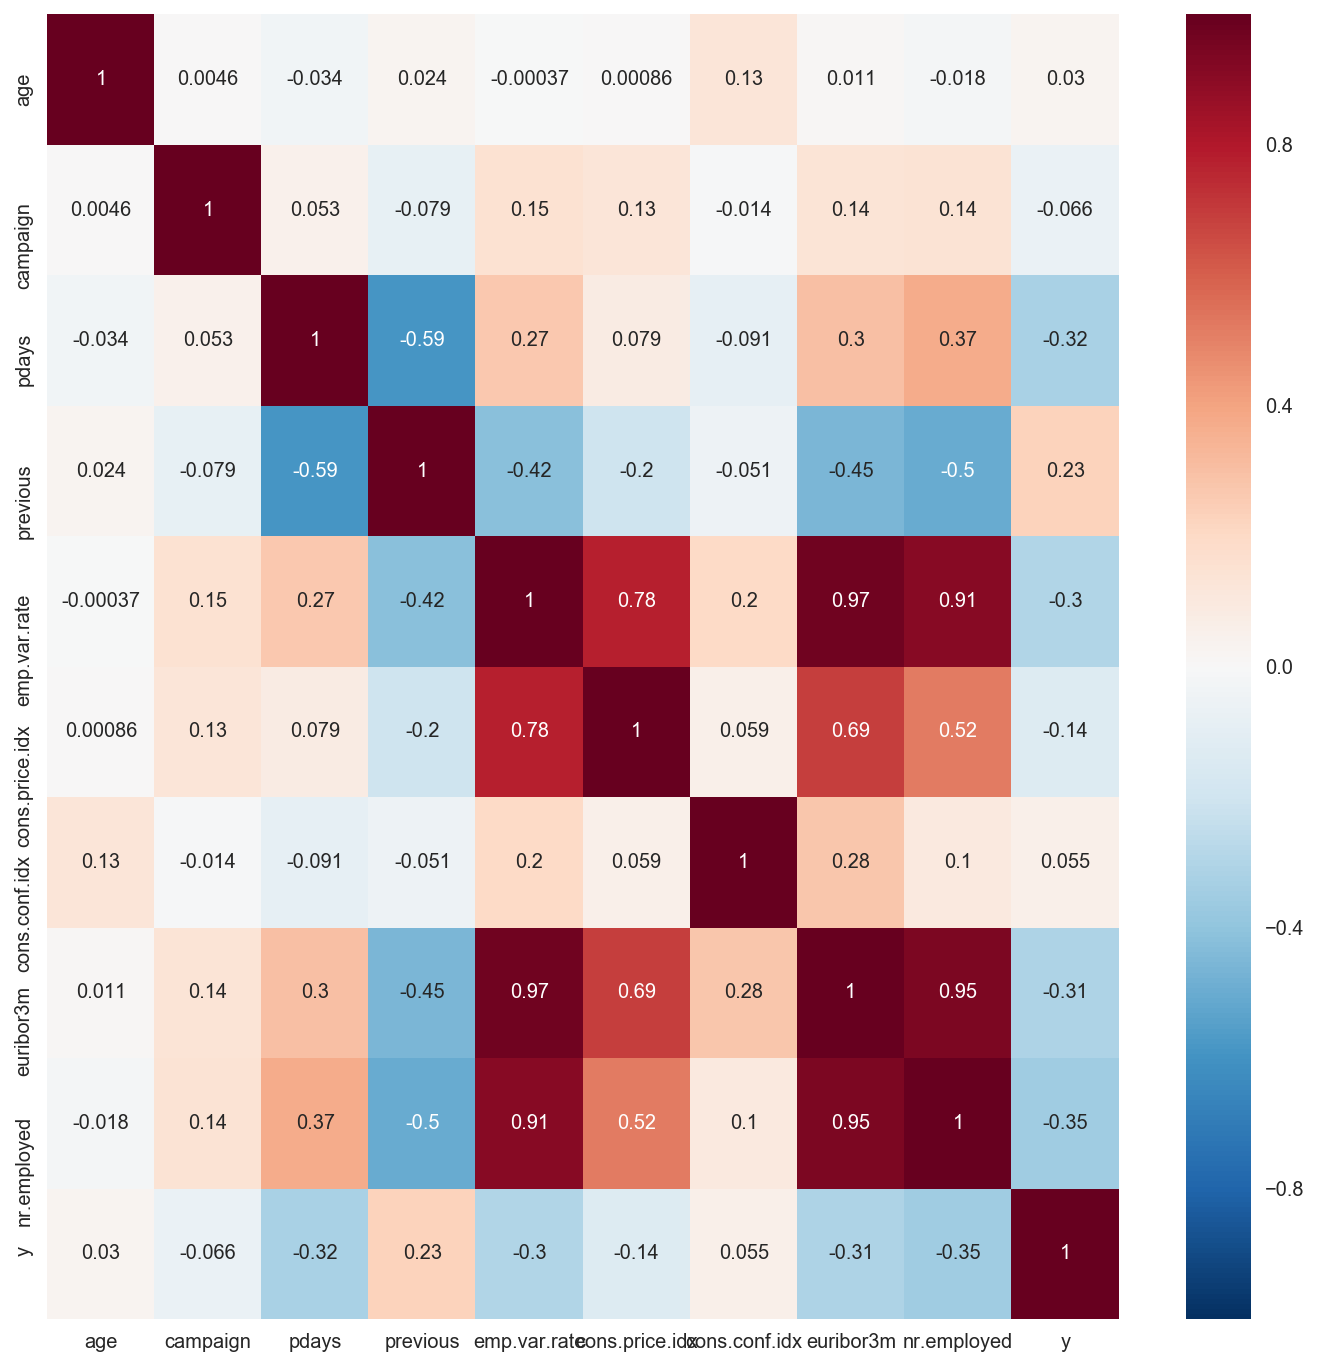

In [13]:
# Examining the relationship between the numerical variables
fig = plt.figure(figsize=(12,12))
bank_corr = bank.corr()
sns.heatmap(bank_corr, annot=True)

In [26]:
bank.month.value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

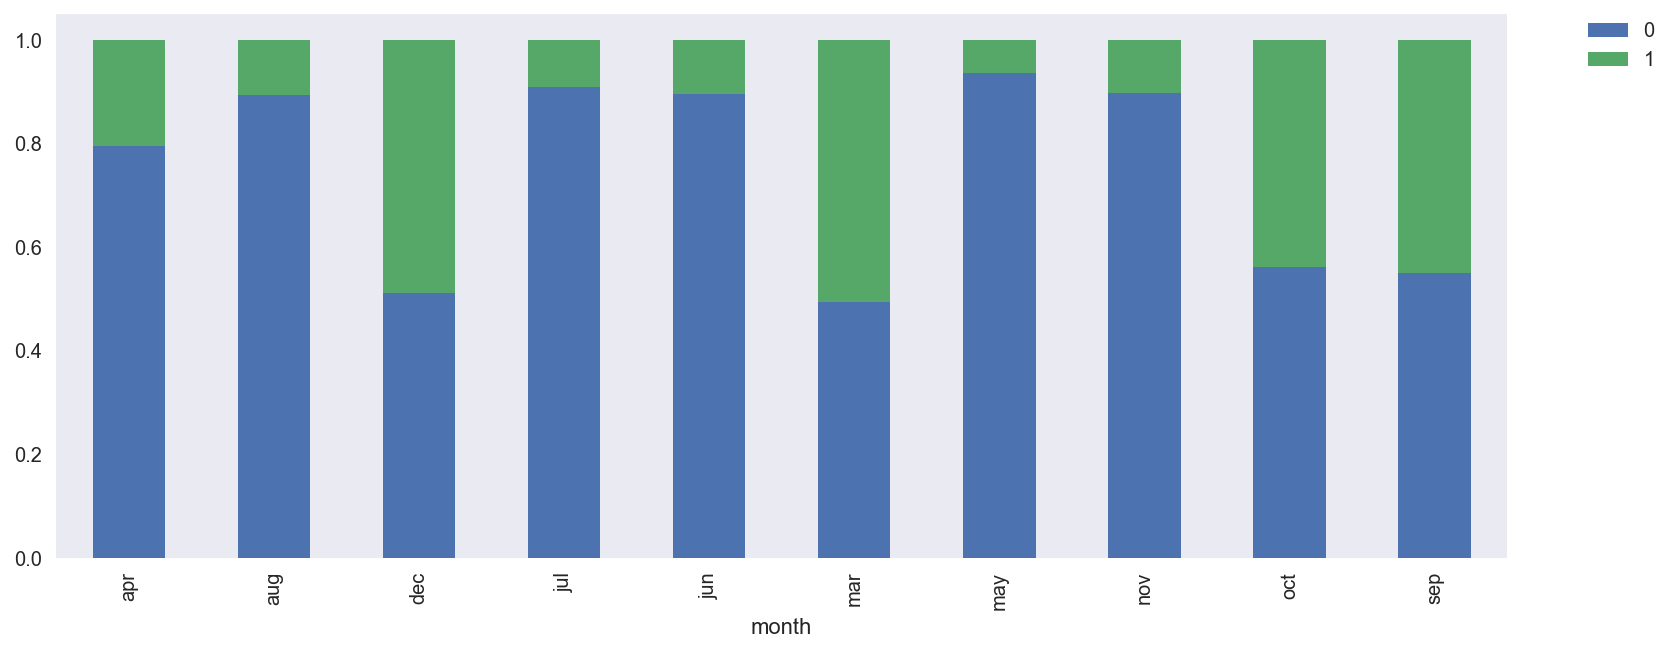

In [60]:
month_rates = pd.crosstab(bank.month, bank.y)
month_rates.div(month_rates.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,grid=False, figsize=(13, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The graph above shows that the months where marketing campaigns have been most successful are March, September, October and December.

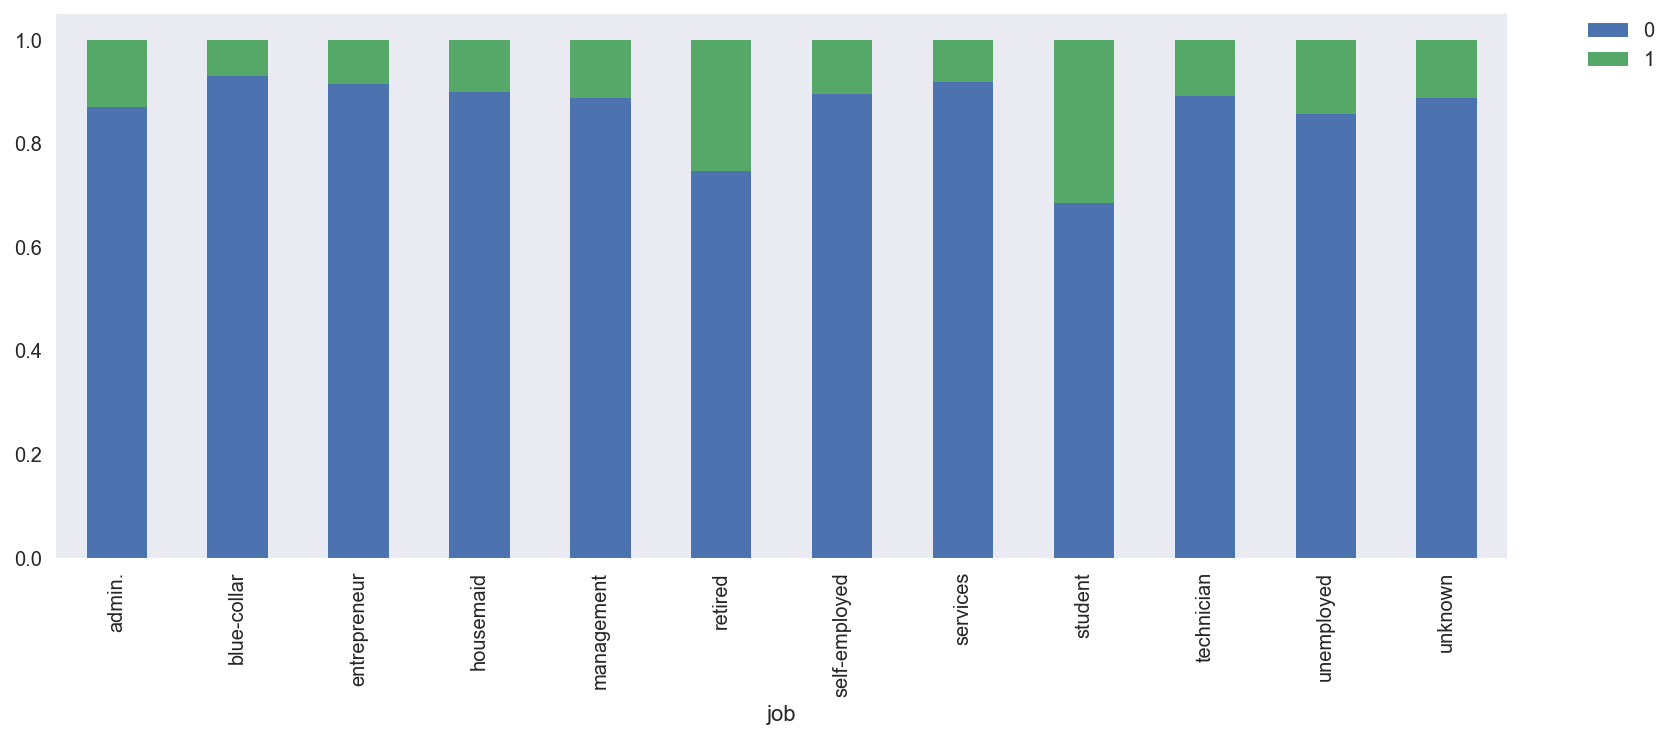

In [61]:
job_rates = pd.crosstab(bank.job, bank.y)
job_rates.div(job_rates.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,grid=False, figsize=(13, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

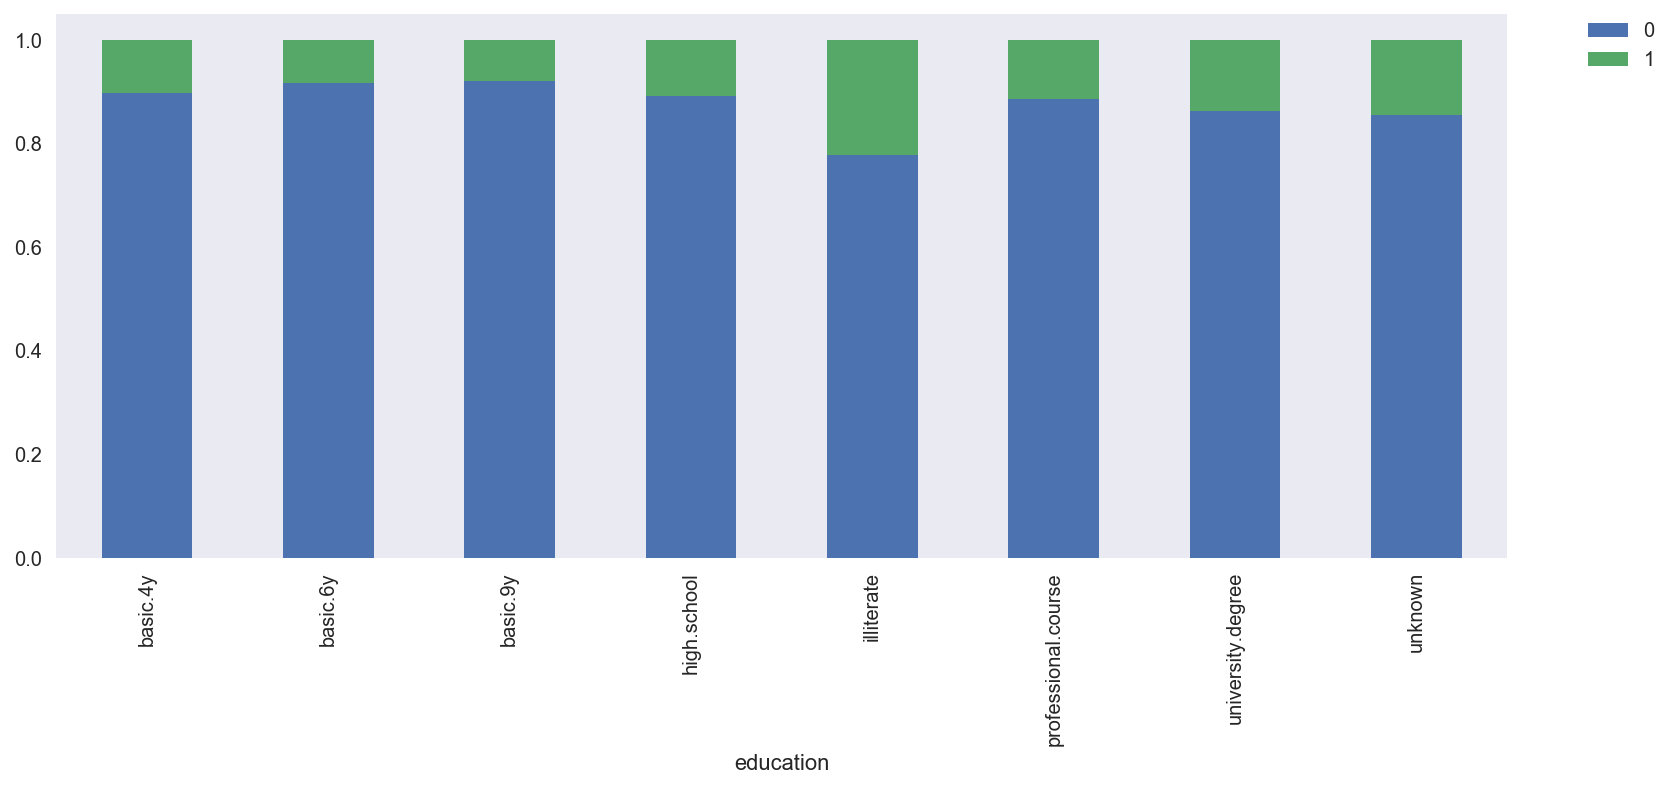

In [62]:
education_rates = pd.crosstab(bank.education, bank.y)
education_rates.div(education_rates.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,grid=False, figsize=(13, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

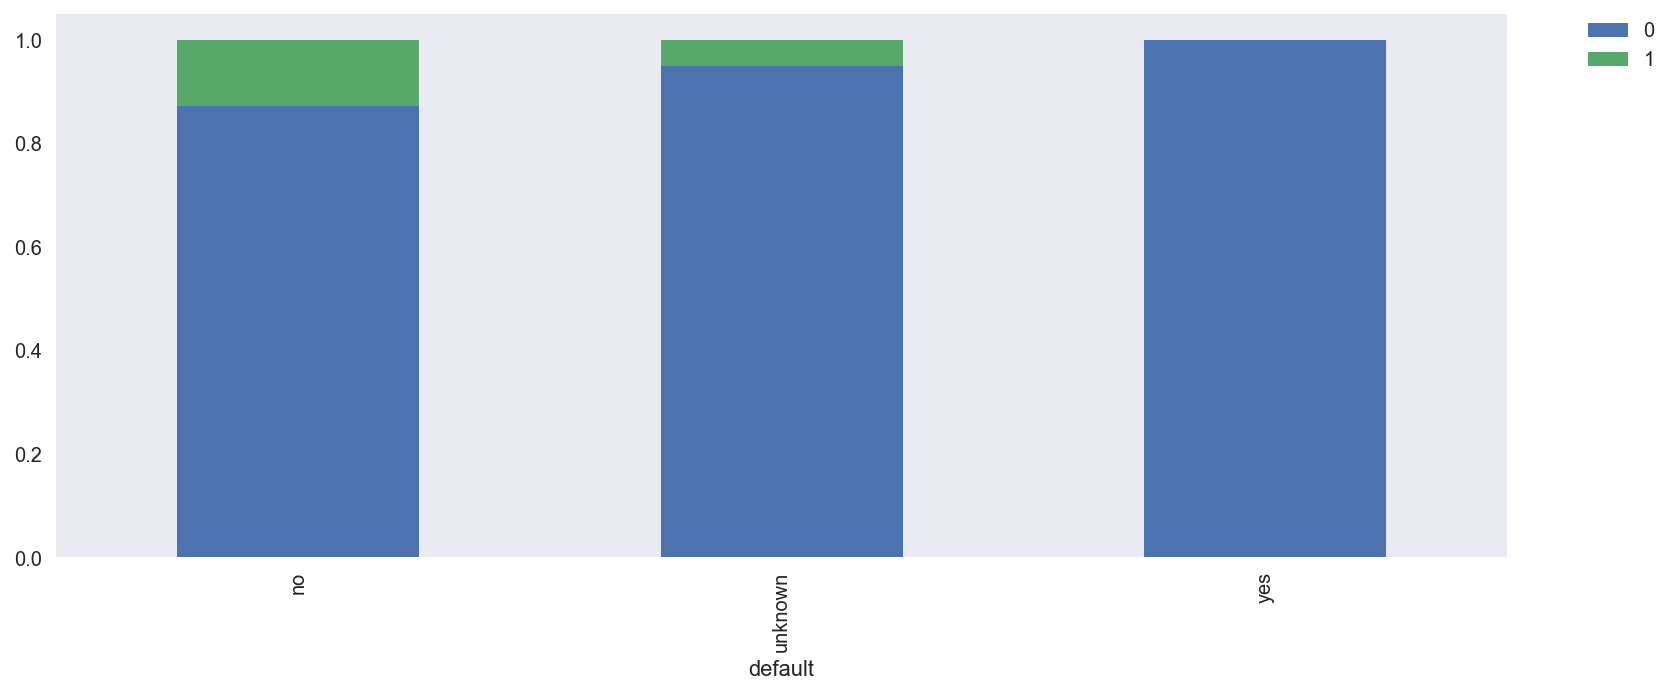

In [64]:
default_rates = pd.crosstab(bank.default, bank.y)
default_rates.div(default_rates.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,grid=False, figsize=(13, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

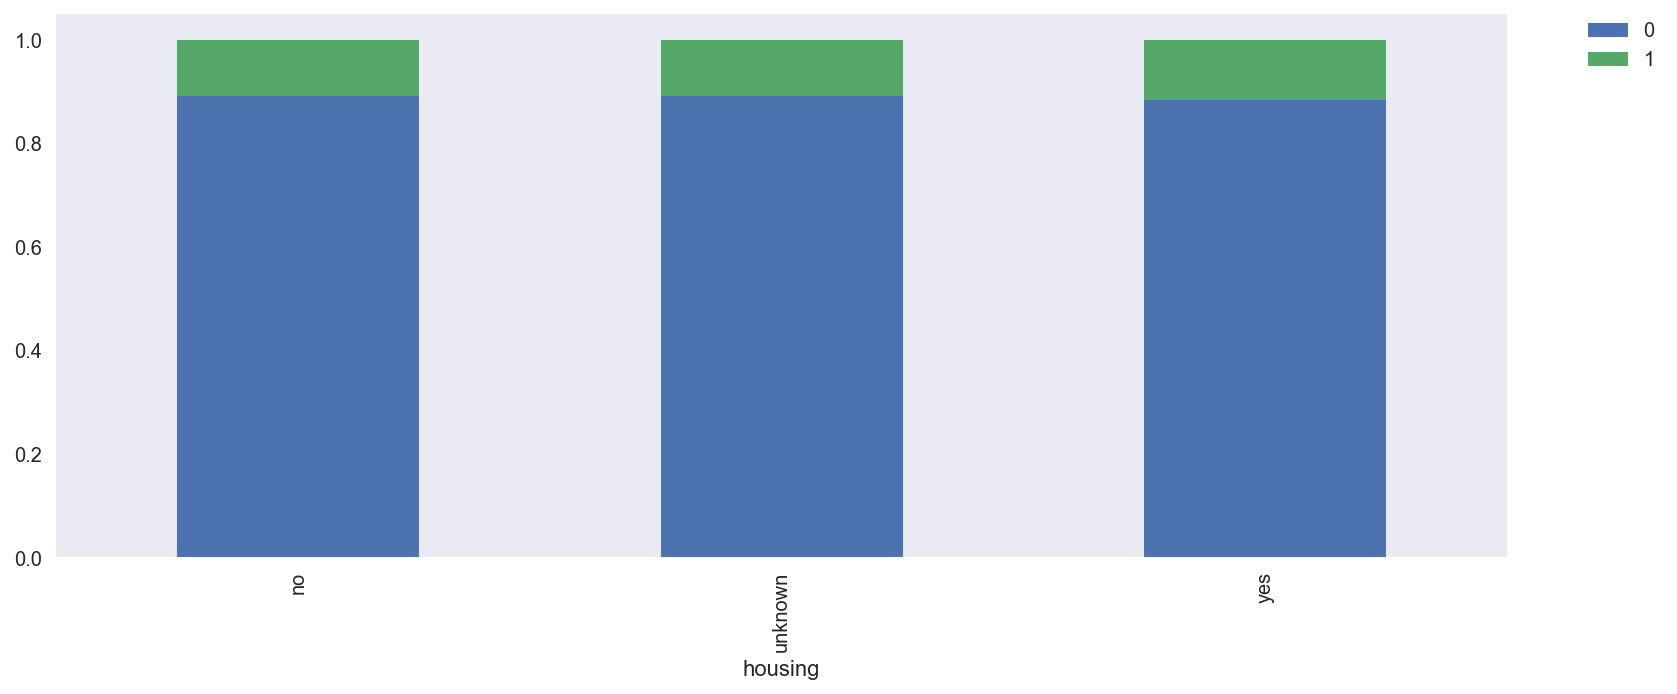

In [65]:
housing_rates = pd.crosstab(bank.housing, bank.y)
housing_rates.div(housing_rates.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,grid=False, figsize=(13, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

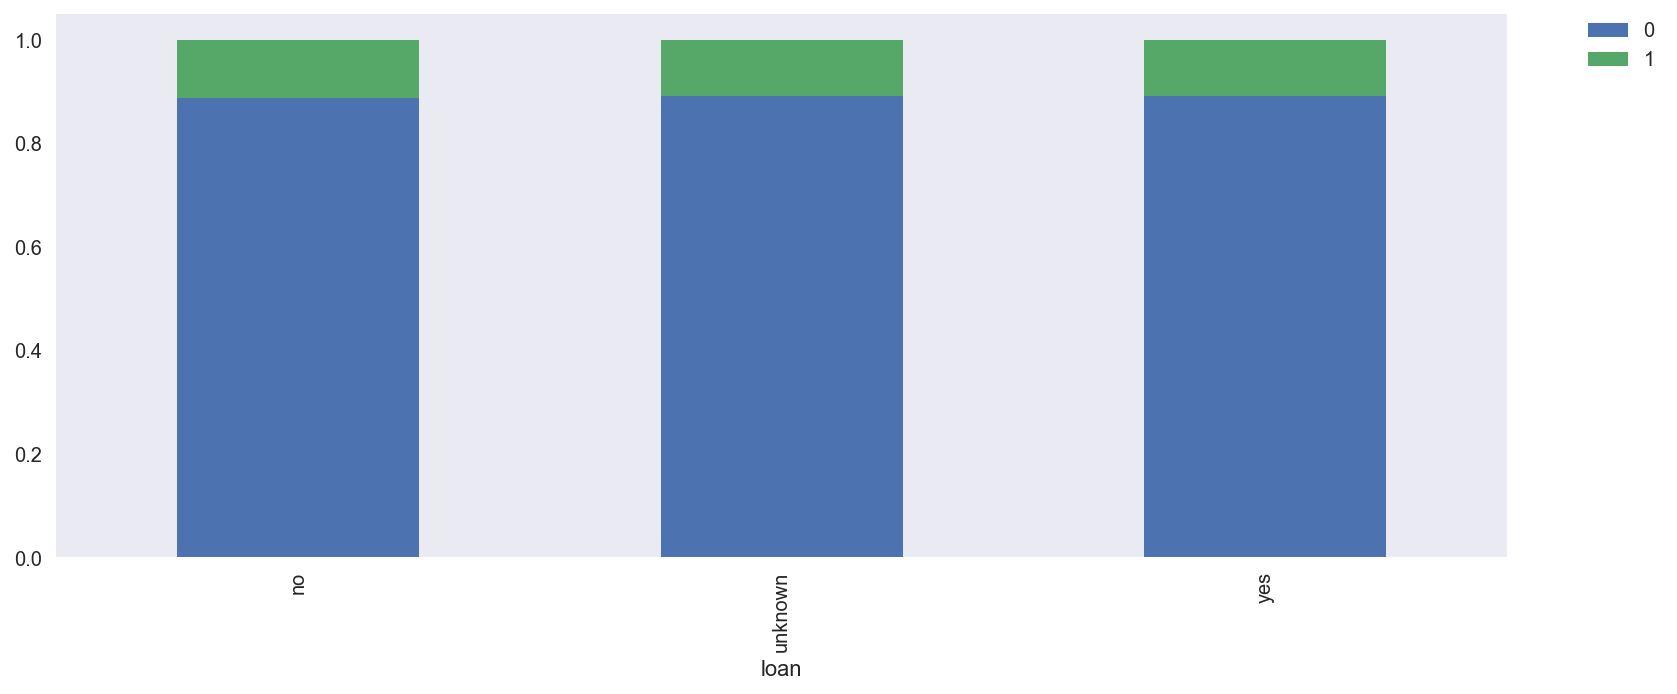

In [66]:
loan_rates = pd.crosstab(bank.loan, bank.y)
loan_rates.div(loan_rates.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,grid=False, figsize=(13, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Which features can best explain whether a customer is going to take up a term deposit?

In [72]:
# selecting a subset of bank dataframe, omitting the economic variables 
bank_df = bank[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
                    'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]


In [73]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [74]:
termd = 'y ~ '+' + '.join([c for c in bank_df.columns if not c == 'y']) + "-1"
print termd

f = termd
y, X = patsy.dmatrices(f, data=bank_df, return_type='dataframe')

y ~ age + job + marital + education + default + housing + loan + contact + month + day_of_week + campaign + pdays + previous + poutcome-1


In [176]:
X.head()

,job[admin.],job[blue-collar],job[entrepreneur],job[housemaid],job[management],job[retired],job[self-employed],job[services],job[student],job[technician],...,day_of_week[T.mon],day_of_week[T.thu],day_of_week[T.tue],day_of_week[T.wed],poutcome[T.nonexistent],poutcome[T.success],age,campaign,pdays,previous
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,56.0,1.0,999.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,57.0,1.0,999.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,37.0,1.0,999.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,40.0,1.0,999.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,56.0,1.0,999.0,0.0


In [157]:
y['y'].value_counts()

0.0    36548
1.0     4640
Name: y, dtype: int64

This is an imbalanced dataset, comprising of only 4640 customers who took up the term deposit out of a total of 41187 customers. The baseline accuracy would be equivalent to 36547/41187 = 0.887.

In [81]:
# Scaling and splitting of data into train and test sets
ss = StandardScaler()
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, train_size=0.7, random_state=21)

/Users/ezekielkuang/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [97]:
# Do a gridsearch on logistic regression (log regression because this is a binary classification task) 
# Will explore Random Forest and Decision Tree Classifiers later
lr = LogisticRegression()

gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)

%time

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 21 µs


In [98]:
lr_gridsearch.fit(X_train, y_train.values.ravel())
# best score on the training data:
lr_gridsearch.best_score_



%time

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.5min finished


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [99]:
# best parameters on the training data:
lr_gridsearch.best_params_

{'C': 0.0095454845666183372, 'penalty': 'l1', 'solver': 'liblinear'}

In [187]:
lr_gridsearch.best_estimator_

LogisticRegression(C=0.0095454845666183372, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [188]:
best_lr = lr_gridsearch.best_estimator_
best_lr.score(X_test, y_test)

0.89641498745650239

In [104]:
best_lr.score(X_train, y_train)

0.89858138808920951

Using logistic regression gives me a 90% accuracy. But I am unable to determine the best features that are predictive of whether a customer actually takes up the term deposit.

### Decision Tree Classifier

In [106]:
from sklearn.tree import DecisionTreeClassifier

In [107]:
# initialize three decision tree classifier instances
dtc1 = DecisionTreeClassifier(max_depth=1)
dtc2 = DecisionTreeClassifier(max_depth=2)
dtc3 = DecisionTreeClassifier(max_depth=3)

In [108]:
dtc1.fit(X, y)
dtc2.fit(X, y)
dtc3.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [115]:
dtc1_scores = cross_val_score(dtc1, X, y.values.ravel(), cv=5)
dtc2_scores = cross_val_score(dtc2, X, y.values.ravel(), cv=5)
dtc3_scores = cross_val_score(dtc3, X, y.values.ravel(), cv=5)

In [116]:
print dtc1_scores, np.mean(dtc1_scores)
print dtc2_scores, np.mean(dtc2_scores)
print dtc3_scores, np.mean(dtc3_scores)

[ 0.8873513   0.89147851  0.90179655  0.91780988  0.88915867] 0.897518984427
[ 0.8873513   0.89147851  0.89536295  0.51207964  0.85662256] 0.808578992527
[ 0.8873513   0.38334547  0.89633406  0.57860872  0.84496783] 0.718121475517


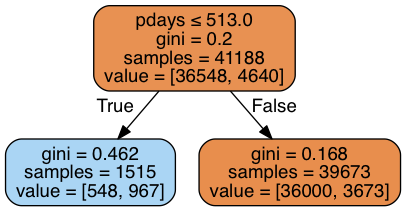

In [121]:
# max depth = 1
dot_data = StringIO()  

export_graphviz(dtc1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

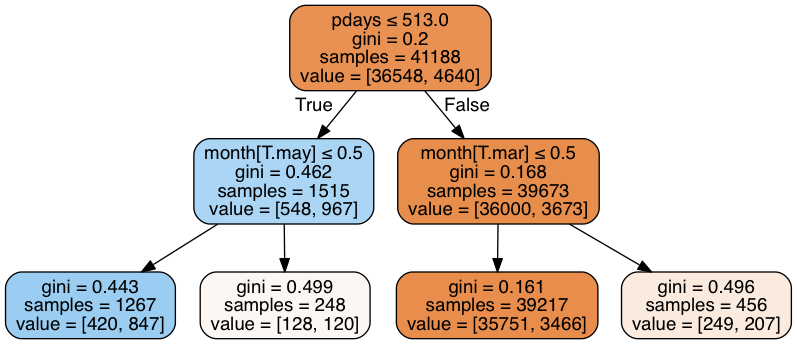

In [122]:
# max_depth = 2
dot_data = StringIO()  

export_graphviz(dtc2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

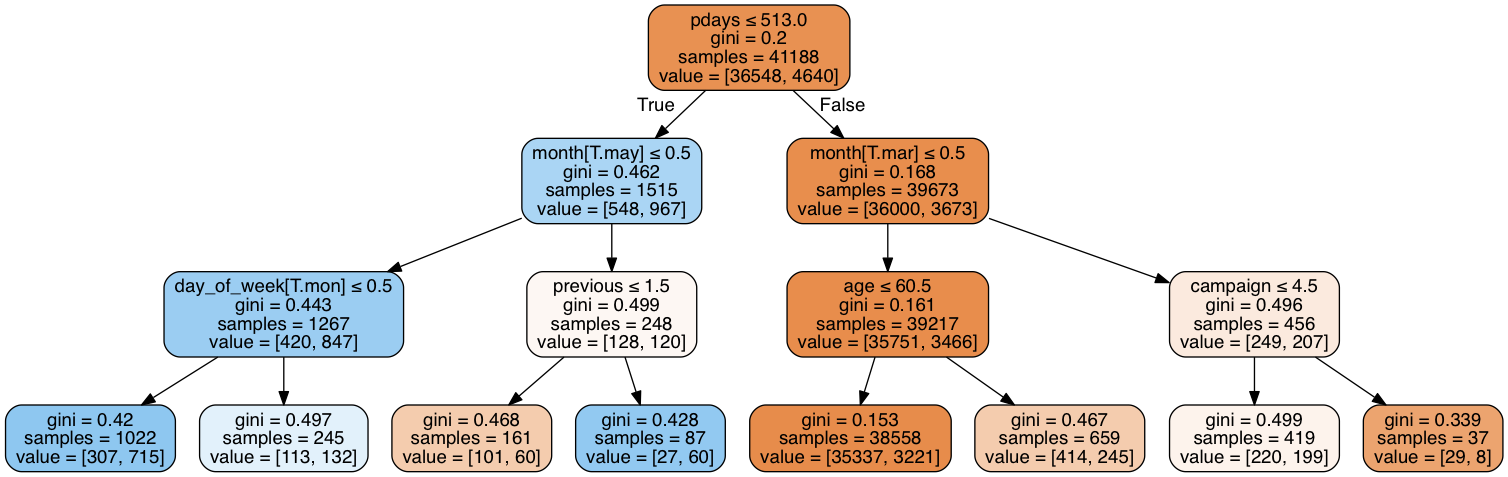

In [123]:
# max_depth = 3
dot_data = StringIO()  

export_graphviz(dtc3, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [125]:
impt3 = dtc3.feature_importances_

In [140]:
feat_imp = pd.DataFrame(X.columns, impt3)
feat_imp.reset_index(inplace=True)
feat_imp.sort_values(by=['index'], ascending=False)

,index,0
46,0.764043,pdays
33,0.105913,month[T.mar]
44,0.094646,age
34,0.012432,month[T.may]
47,0.009978,previous
38,0.008988,day_of_week[T.mon]
45,0.004001,campaign
26,0.000000,loan[T.unknown]
27,0.000000,loan[T.yes]
28,0.000000,contact[T.telephone]


In [175]:
# Narrowing down the features that matter the most according to decision tree
X2 = X[['pdays','month[T.mar]','age','month[T.may]','previous','day_of_week[T.mon]','campaign']]

In [177]:
# Scaling and splitting of data into train and test sets
ss = StandardScaler()
Xs2 = ss.fit_transform(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xs2, y, train_size=0.7, random_state=21)

In [178]:
# Do a gridsearch on logistic regression again based on the narrowed features
lr2 = LogisticRegression()

gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr2_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)

%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 15 µs


In [179]:
lr2_gridsearch.fit(X_train2, y_train2.values.ravel())
# best score on the training data:

%time

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.01 µs


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.4s finished


In [192]:
lr2_gridsearch.best_score_
# best parameters on the training data:

0.8991363462939197

In [193]:
lr2_gridsearch.best_params_

{'C': 0.0047508101621027985, 'penalty': 'l1', 'solver': 'liblinear'}

In [194]:
best_lr2 = lr2_gridsearch.best_estimator_

In [197]:
best_lr2

LogisticRegression(C=0.0047508101621027985, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [196]:
best_lr2.score(X_test2, y_test2)

0.89746702274014734

#### Improvement from 0.8964 to 0.8975, but not very significant

In [199]:
# Log Regression with random undersampling

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb

logpipe = make_pipeline_imb(
    RandomUnderSampler(), # undersamples majority class
    LogisticRegression(penalty='l1', solver='liblinear', C=0.0095454845666183372)  
)

logpipe.fit(X_train2, y_train2)
logpipe_pred = logpipe.predict(X_test2)
logpipe_pred_proba = logpipe.predict_proba(X_test2)
log = logpipe.score(X_test2, y_test2)

print classification_report(y_test2, logpipe_pred)

             precision    recall  f1-score   support

        0.0       0.93      0.73      0.82     10955
        1.0       0.20      0.54      0.30      1402

avg / total       0.84      0.71      0.76     12357



In [200]:
# Decision Tree Classifier with random undersampling

dtc_pipe = make_pipeline_imb(
    RandomUnderSampler(), # undersamples majority class
    DecisionTreeClassifier(max_features=None, min_samples_split=2, max_depth=1)  
)

dtc_pipe.fit(X_train2, y_train2)
dtc_pipe_pred = dtc_pipe.predict(X_test2)
dtc_pipe_pred_proba = dtc_pipe.predict_proba(X_test2)
dtc = dtc_pipe.score(X_test2, y_test2)

print classification_report(y_test2, dtc_pipe_pred)

             precision    recall  f1-score   support

        0.0       0.91      0.99      0.94     10955
        1.0       0.64      0.20      0.31      1402

avg / total       0.88      0.90      0.87     12357



### Summary and Conclusions


- Presence of a housing or personal loan seems to have no effect on the success rate of the campaign. <br>
- In terms of education level, the current marketing campaign has the highest success rate among the illiterate. <br>
- By occupation, the retired and student groups have the highest success rate. <br>
- If the customer is already in default, they are almost certainly going to reject taking up another term deposit. This is fairly obvious since they do not even have enough cash to service their debt payments.
- It turns out that March and May are fairly predictive months for the customer taking up the term deposit. Future campaigns could include factoring in additional resources for marketing in these months (ramping up number of calls to clients, increasing online and offline media presence, etc)
- Simple classifiers achieved a score of 0.87, while the score for a balanced dataset was 0.76. Most notably the recall score is weak, and is a probably a function of the limitations of the dataset (low number of samples). The number of categorical features in the dataset was high, and if I could have more numerical information the model could possibly have performed better. The lowest-hanging fruit in terms of additional data could be including each customer's salary; other information points could include a count of the number of other investment products that each customer has with the bank.